# Word Vectors

En este trabajo, utilizaremos **embeddings** para resolver un problema de clasificación de texto. Los embeddings, representaciones distribuidas y vectoriales de elementos, son un concepto muy común en el mundo del deep learning. Los **word vectors** que hemos visto en clase son una representación en forma de embedding de las palabras.

Para realizar este trabajo y sacarle el máximo partido, se recomienda ver los siguientes vídeos de clase:

*   Clasificación de texto con Word Vectors.
*   Análisis de overfitting con un modelo bag of words.
*   Clasificación de texto con RNN

Vamos a utilizar el dataset **"Reuters newswire topics classification"**, disponible desde Keras de manera similar al dataset de IMDB ([ver documentación](https://keras.io/datasets/#reuters-newswire-topics-classification)).

---

Se pide:

Entrenar un modelo **utilizando embeddings** que consiga un **65% de accuracy en test (55% si usamos RNNs)**, mostrando el entrenamiento y el resultado final.
 
Tenemos varias opciones para entrenar modelos con embeddings. El alumno puede explorar más de una pero es suficiente con conseguir un modelo que alcance la accuracy requerida:

*   Utilizar una **media de embeddings** al estilo de lo visto en el vídeo *Clasificación de texto con Word Vectors*
*   Utilizar una **CNN** sobre una secuencia de word vectors. Aquí necesitamos cambiar un poco la idea de convolución para actuar sobre sequencias de vectores. Keras incluye una [Convolución en 1D](https://keras.io/layers/convolutional/#conv1d) que puede ser utilizada en este caso, con un ejemplo de uso en la documentación. Una forma de hacer funcionar este esquema sería utilizar la convolución en 1D + max pooling.
*  Utilizar una **RNN** sobre una secuencia de word vectors, al estilo de lo visto en el vídeo *Clasificación de texto con RNN*. Para este problema es un poco complicado conseguir un buen modelo con RNNs, y además es más difícil experimentar ya que las redes recurrentes son modelos lentos de entrenar. Por eso, es suficiente con alcanzar un 55% de accuracy si optamos por utilizar un modelo de este estilo. Un buen consejo es emplear una red recurrente bidireccional como se ve en el vídeo *Clasificación de texto con RNN*.



---

Dos hiperparámetros importantes a elegir en el modelo son la **longitud de las secuencias de texto** y el **tamaño del vocabulario** para los embeddings. Podéis experimentar con ambos, o utilizar los mismos que se usan en los vídeos. Nótese que, al cortar todas las secuencias para que tengan el mismo tamaño, podríamos estar perdiendo mucho texto si elegimos un tamaño de secuencia demasiado pequeño. Igualmente, si las hacemos muy largas necesitaremos más tiempo para entrenar nuestros modelos. Una buena idea consiste en explorar los datos para ver cómo suelen ser de largos los textos y encontrar un buen trade-off para el tamaño de al secuencia.



---

Los embeddings que hemos visto en los vídeos se entrenan junto al modelo.  Una técnica frecuente es inicializar estos embeddings con word-vectors pre-entrenados en un gran corpus de texto, como hemos visto en clase. Esto puede ayudar ya que nuestro modelo empieza con unos embeddings que ya encapsulan significado. Si bien no es necesario para esta práctica, podéis ver cómo usar esta técnica [en el siguiente tutorial](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).




## Entrenamiento del Model

### Importación del Librerías

In [1]:
import numpy as np
import keras
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers

Using TensorFlow backend.


### Pre-procesamiento
En primer lugar, se carga los datos haciendo uso de la librería *reuters*. Además se hace un split en la carga para tener un 20% de datos de test.

In [2]:
!pip install numpy==1.16.1
import numpy as np

from keras.datasets import reuters

max_words = 10000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(path="reuters.npz",
                                                         num_words=max_words,
                                                         skip_top=0,
                                                         maxlen=None,
                                                         test_split=0.2,
                                                         seed=113,
                                                         start_char=1,
                                                         oov_char=2,
                                                         index_from=3)

Loading data...


Cada frase de nuestro dataset tiene una longitud distinta, por lo que es necesario normalizarlo para que estas sean iguales a lo largo del dataset.

In [3]:
lenths = [len(x) for x in x_train]
print(lenths)

[87, 56, 139, 224, 101, 116, 100, 100, 82, 106, 31, 59, 65, 316, 527, 76, 114, 17, 91, 77, 231, 108, 83, 29, 95, 110, 23, 373, 114, 354, 133, 222, 571, 155, 83, 208, 170, 269, 74, 19, 23, 78, 21, 377, 104, 299, 89, 56, 94, 139, 118, 36, 137, 107, 83, 66, 70, 112, 88, 51, 83, 123, 17, 185, 84, 52, 102, 73, 106, 486, 107, 82, 263, 172, 491, 190, 143, 62, 26, 88, 114, 38, 85, 112, 793, 104, 25, 21, 101, 28, 25, 81, 135, 73, 62, 18, 90, 266, 91, 64, 409, 92, 319, 166, 85, 200, 152, 474, 60, 58, 584, 71, 273, 51, 255, 28, 171, 143, 91, 46, 110, 77, 162, 24, 52, 175, 61, 95, 97, 259, 112, 73, 94, 17, 650, 23, 88, 309, 105, 89, 41, 314, 54, 374, 67, 160, 75, 207, 373, 84, 87, 74, 98, 136, 256, 95, 50, 108, 52, 100, 233, 86, 68, 47, 73, 158, 113, 23, 100, 80, 202, 104, 122, 101, 95, 118, 253, 192, 80, 183, 29, 604, 41, 103, 63, 147, 472, 58, 23, 37, 98, 73, 122, 812, 51, 179, 56, 60, 60, 25, 212, 34, 406, 122, 27, 86, 83, 43, 208, 26, 159, 65, 48, 335, 701, 314, 333, 68, 263, 124, 337, 180, 67

Para ello, se hace uso del método *pad_sequences* el cual permite normalizar estos datos con un máximo de longitud (en este caso 256).  
En caso de que la longitud sea mayor, esta se recortará por las 256 palabras más relevantes y en caso de que sea menor, se añadirán 0 al final.

In [0]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=0,
                                                        padding='post',
                                                        maxlen=256)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=0,
                                                       padding='post',
                                                       maxlen=256)

Tras aplicar el algoritmo, se puede observar como todos los datos tienen una longitud fija de 256.

In [5]:
lenths = [len(x) for x in x_train]
print(lenths)

[256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256,

Además, para obtener el número de clases a predecir, se obtiene de la variable y los valores únicos y se aplica la función *len* para obtener el número de clases a predecir.

In [0]:
num_clases = len(np.unique(y_train))


También se crea una función que permite poder visualizar en dos gráficas el Accuracy y el Loss de un modelo, para sus datos de entrenamiento y sus datos de validación

In [0]:
def plot_hist(history):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.set_title("Model Accuracy")
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='upper left')
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title("Model Loss")
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper right')
    
    f.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    

### Entrenamiento

Para el entrenamiento se hace uso de distintos tipos de modelos:
* Media de embeddings
* CNN
* RNN

#### Media de embeddings

A continuación se muestra el entrenamiento haciendo uso de *GlobalAveragePooling1D*.

In [8]:
model = keras.Sequential()
model.add(keras.layers.Embedding(10000, 256))

model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(256, activation='relu'))

model.add(keras.layers.Dense(num_clases, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=64,
                    validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 46)                11822     
Total params: 2,637,614
Trainable params: 2,637,614
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 7185 samples, validate on 1797 samples
Epoch 1/20
7185/7185 [==============================] - 9s 1ms/step - loss: 2.5499 - acc: 0.3602

Como se puede ver en las gráficas posteriores, a partir de las 6 epochs, los datos de validación no obtenien una mejora sifnificativa y el modelo cae en overfitting, por lo que se decide finalmente generar un modelo con 6 epochs.

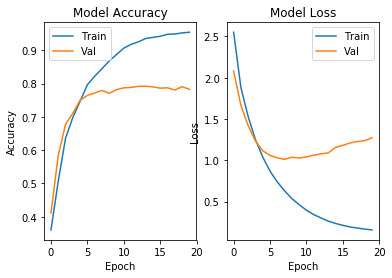

In [9]:
plot_hist(history)

A continuación, se muestra el modelo resultante, el cual tiene una precisión de __74.22%__

In [15]:
model = keras.Sequential()
model.add(keras.layers.Embedding(10000, 256))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(num_clases, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=0)

model.evaluate(x_test, y_test)

2246/2246 [==============================] - 0s 138us/step


[1.1387509750874045, 0.7422083704894075]

#### CNN

A continuación se crea una red haciendo uso de CNN mediante la capa *Con1D*. 

In [11]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(10000, embedding_dim, input_length=256))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_clases, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train,
                    epochs=10,
                    verbose=1,
                    batch_size=64,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 256, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 252, 128)          64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_6 (Dense)              (None, 46)                1518      
Total params: 1,069,774
Trainable params: 1,069,774
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 7185 samples, validate on 1797 samples
Epoch 

Este modelo comienza a caer en overfitting a partir de las 7 epochs, donde los datos de validación no mejoran

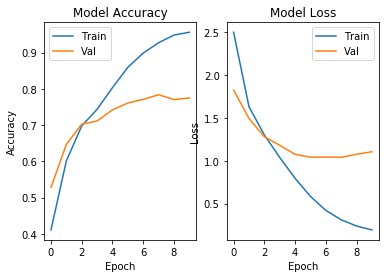

In [12]:
plot_hist(history)

Finalmente, se crea el modelo usando únicamente 7 epochs, dando una precisión de __76.80%__





In [13]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(10000, embedding_dim, input_length=256))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(num_clases, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train,
                    epochs=7,
                    verbose=0,
                    batch_size=64,
                    validation_split=0.2)

model.evaluate(x_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 256, 100)          1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 252, 128)          64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_8 (Dense)              (None, 46)                1518      
Total params: 1,069,774
Trainable params: 1,069,774
Non-trainable params: 0
_________________________________________________________________
2246/2246 [==============================] - 2s 940us/step


[1.0109266313398297, 0.768032057043281]

#### RNN

Para hacer uso de una RNN, se usa la librería LSTM la cual implementa una RNN--------------------------

In [16]:
model = Sequential()
model.add(layers.Embedding(10000, 256, input_length=256))
model.add(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_clases, activation='softmax'))
model.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train,
                    epochs=20,
                    verbose=1,
                    batch_size=64,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 256, 256)          2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                36992     
_________________________________________________________________
dense_12 (Dense)             (None, 46)                1518      
Total params: 2,598,510
Trainable params: 2,598,510
Non-trainable params: 0
_________________________________________________________________
Train on 7185 samples, validate on 1797 samples
Epoch 1/20
7185/7185 [==============================] - 55s 8ms/step - loss: 2.5246 - acc: 0.3530 - val_loss: 2.3753 - val_acc: 0.3534
Epoch 2/20
7185/7185 [==============================] - 53s 7ms/step - loss: 2.3651 - acc: 0.3645 - val_loss: 2.3483 - val_acc: 0.3617
Epoch 3/20
7185/7185 [==============================] - 53s 7ms/step - loss: 2

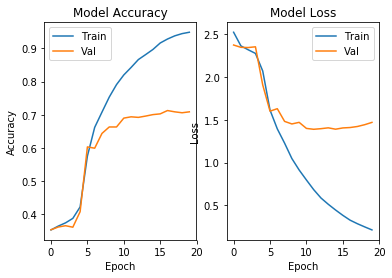

In [17]:
plot_hist(history)

In [18]:
model = Sequential()
model.add(layers.Embedding(10000, 256, input_length=256))
model.add(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_clases, activation='softmax'))
model.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(x_train, y_train,
                    epochs=11,
                    verbose=1,
                    batch_size=64,
                    validation_split=0.2)
model.evaluate(x_test, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 256, 256)          2560000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                36992     
_________________________________________________________________
dense_13 (Dense)             (None, 46)                1518      
Total params: 2,598,510
Trainable params: 2,598,510
Non-trainable params: 0
_________________________________________________________________
Train on 7185 samples, validate on 1797 samples
Epoch 1/11
7185/7185 [==============================] - 56s 8ms/step - loss: 2.5415 - acc: 0.3530 - val_loss: 2.3762 - val_acc: 0.3534
Epoch 2/11
7185/7185 [==============================] - 54s 8ms/step - loss: 2.3674 - acc: 0.3602 - val_loss: 2.3842 - val_acc: 0.3428
Epoch 3/11
7185/7185 [==============================] - 54s 8ms/step - loss: 2

[1.5629598436245191, 0.6335707925731119]

Finalmente, se crea el modelo usando únicamente 11 epochs, dando una precisión de __63.35%__